# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Egl-9-is-epistatic-to-vhl-1" data-toc-modified-id="Egl-9-is-epistatic-to-vhl-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Egl-9 is epistatic to vhl-1</a></div><div class="lev1 toc-item"><a href="#hif-1-suppresses-egl-9" data-toc-modified-id="hif-1-suppresses-egl-9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>hif-1 suppresses egl-9</a></div><div class="lev1 toc-item"><a href="#Transitivity-holds-in-transcriptomes" data-toc-modified-id="Transitivity-holds-in-transcriptomes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transitivity holds in transcriptomes</a></div><div class="lev2 toc-item"><a href="#Predicting-the-epistasis-between-egl-9-and-vhl-1-using-the-rhy-1-transcriptome" data-toc-modified-id="Predicting-the-epistasis-between-egl-9-and-vhl-1-using-the-rhy-1-transcriptome-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Predicting the epistasis between <em>egl-9</em> and <em>vhl-1</em> using the <em>rhy-1</em> transcriptome</a></div><div class="lev2 toc-item"><a href="#Predicting-the-epistasis-between-egl-9-and-hif-1-using-the-rhy-1-transcriptome" data-toc-modified-id="Predicting-the-epistasis-between-egl-9-and-hif-1-using-the-rhy-1-transcriptome-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Predicting the epistasis between <em>egl-9</em> and <em>hif-1</em> using the <em>rhy-1</em> transcriptome</a></div>

In [31]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import epistasis as epi
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from scipy.stats import gaussian_kde

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [32]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [33]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [34]:
genvar = gvars.genvars()

In [35]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]

tidy_data = pd.concat(frames)

In [36]:
hifoh = pd.read_csv('../output/hifoh_candidates.csv')

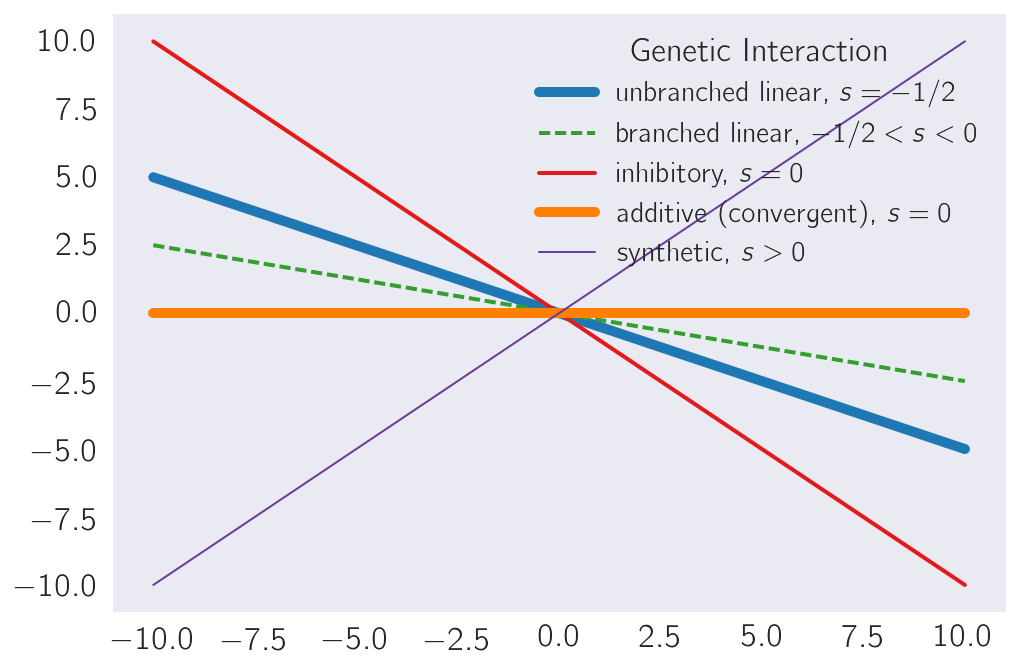

In [37]:
X = np.linspace(-10, 10)
Y = -1/2*X

plt.plot(X, -1/2*X, ls='-', color= '#1f78b4', lw=5, label='unbranched linear, $s=-1/2$')
plt.plot(X, -1/4*X, ls='--', color= '#33a02c', label='branched linear, $-1/2 < s < 0$')
plt.plot(X, -X, ls='-', lw=2, color= '#e31a1c', label='inhibitory, $s = 0$')
plt.plot(X, 0*X, 'k-', lw=5, color= '#ff7f00', label='additive (convergent), $s = 0$')
plt.plot(X, X, '-', lw=1,color= '#6a3d9a',  label='synthetic, $s > 0$')

lgd = plt.legend()
lgd.set_title('Genetic Interaction', prop=(mpl.font_manager.FontProperties(size=16)))
plt.savefig('../output/epistasis_plot_show.svg', bbox_inches='tight')

# Egl-9 is epistatic to vhl-1

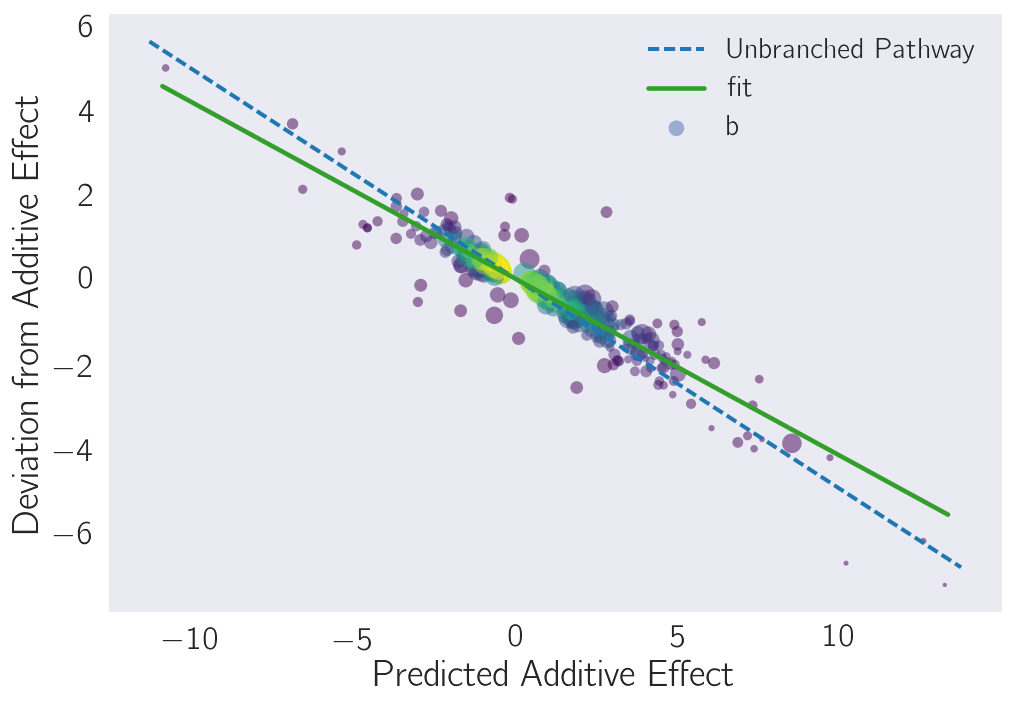

In [180]:
letter1 = 'b'
letter2 = 'd'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2], double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [181]:
s = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=1000)

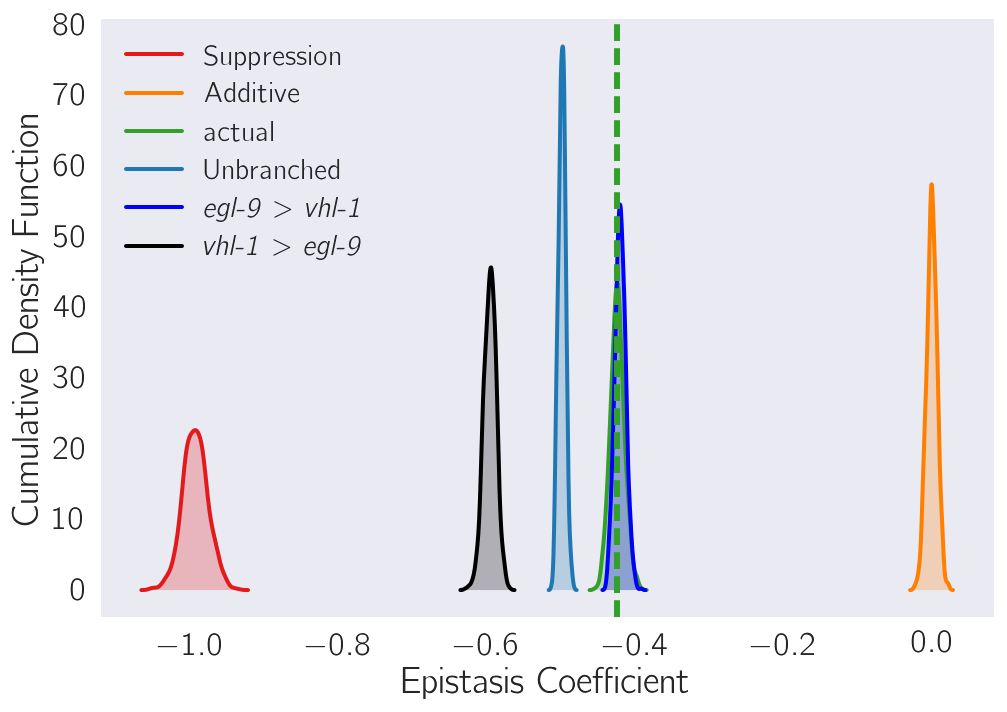

In [182]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=False, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [183]:
# calculate slope from the data:
actual = epi.ODR([x,y], xy, epistasis='actual')
actual.pprint()

Beta: [-0.42087079]
Beta Std Error: [ 0.00770878]
Beta Covariance: [[ 0.0001708]]
Residual Variance: 0.34792851824910975
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [184]:
import scipy

In [185]:
# bayes model fitting:

def log_prior_fixed(theta):
    sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return - np.log(sigma)

def log_likelihood_fixed(theta, x, y, model, alpha):
    sigma = theta
    epistasis = ['actual', 'xy=x', 'xy=y', 'xy=x=y', 'xy=x+y',
                 'suppress']
    if model not in epistasis:
        raise ValueError('model is not allowed')

    if model == 'xy=x+y':
        y_model = 0

    elif model == 'xy=x=y':
        y_model = -1/2*x

    elif model == 'suppress':
        y_model = -x

    elif (model == 'xy=x') or (model == 'xy=y'):
        y_model = alpha[model]*x

    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior_fixed(theta, x, y, model, alpha):
    return log_prior_fixed(theta) + log_likelihood_fixed(theta, x, y, model, alpha)

def neg_log_prob_fixed(theta, x, y, model, alpha):
    return -log_posterior_fixed(theta, x, y, model, alpha)

In [186]:
# bayes model fitting:
def log_likelihood_fixed(w, x, y, model, alpha):
    sigma = w
    epistasis = ['actual', 'xy=x', 'xy=y', 'xy=x=y', 'xy=x+y',
                 'suppress']
    if model not in epistasis:
        raise ValueError('model is not allowed')

    if model == 'xy=x+y':
        y_model = 0

    elif model == 'xy=x=y':
        y_model = -1/2*x

    elif model == 'suppress':
        y_model = -x

    elif (model == 'xy=x') or (model == 'xy=y'):
        y_model = alpha[model]*x

    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior_fixed(w, x, y, model, alpha):
    return log_likelihood_fixed(w, x, y, model, alpha)

def neg_log_prob_fixed(w, x, y, model, alpha):
    return -log_posterior_fixed(w, x, y, model, alpha)

In [187]:
def log_prior(theta):
#     beta, sigma = theta
    beta = theta
#     if sigma < 0:
#         return -np.inf  # log(0)
#     else:
    return -1.5 * np.log(1 + beta ** 2) #- np.log(sigma)

def log_likelihood(theta, x, y, w):
#     beta, sigma = theta
    beta = theta
    sigma = w
    y_model = beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y, w):
    return log_prior(theta) + log_likelihood(theta, x, y, w)

def neg_log_prob_free(theta, x, y, w):
    return -log_posterior(theta, x, y, w)

In [210]:
import statsmodels.tools.numdiff as smnd

def model_selection(X, Y, wdev, alpha, **kwargs):
    guess = kwargs.pop('guess', -0.5)
    
    # calculate probabilities for fixed models

    # calculate probability of free model:
#     guess = np.array([guess, 1])
    res = scipy.optimize.minimize(neg_log_prob_free, guess, args=(X, Y, wdev), method='Powell')
    
    # Compute error bars
    if len(np.atleast_1d(res.x)) > 1: 
        hes_free = smnd.approx_hess(res.x, log_posterior, args=(X, Y, wdev))
        cov_free = -np.linalg.inv(smnd.approx_hess(res.x, log_posterior, args=(X, Y, wdev)))
        alpha_free = res.x[0]
        sigma_free = res.x[1]
        log_free = log_posterior([alpha_free, sigma_free], X, Y, wdev)
    else:
        second_derivative = scipy.misc.derivative(log_posterior, res.x, dx=1.0, n=2, args=(X, Y, wdev), order=3)
        cov_free = -1/second_derivative
        alpha_free = np.float64(res.x)
        log_free = log_posterior(alpha_free, X, Y, wdev)
    
    # log goodness of fit for fixed models
    
    eps = ['xy=x', 'xy=y', 'xy=x=y', 'xy=x+y',
           'suppress']
    good_fits = {}
    
    for epistasis in eps:
#         res = scipy.optimize.minimize(neg_log_prob_fixed, 1, args=(X, Y, epistasis, alpha), method='Powell')
#         cf = -1/res.x

        sigma_fixed = res.x
        log_MAP = log_posterior_fixed(wdev, X, Y, model=epistasis, alpha=alpha)
        
        good_fits[epistasis] = log_free - log_MAP


        # occam factor - only the free model has a penalty
        if type(cov_free) is np.float64:
            log_occam_factor =(-np.log(2 * np.pi) + np.log(cov_free) 
                               - 0) / 2
        else:
            log_occam_factor =(-np.log(2 * np.pi) + np.log(np.linalg.det(cov_free)) 
                               - 0) / 2
        
        # give more standing to simpler models. but just a little bit!
        lg = log_free - log_MAP + log_occam_factor - 2
        print('{0} Odds Ratio: {1:2g}'.format(epistasis, np.exp(lg)))

    if type(cov_free) is np.float64:
        std = np.float64(np.sqrt(cov_free))
        print('the value used for the observed fit was {0:.3g} +/- {1:.3g}'.format(alpha_free, std))
    else:
        print('the value used for the observed fit was {0:.3g} +/- {1:.3g}'.format(alpha_free, np.sqrt(cov_free[0][0])))

#     # print the odds ratio
#     print('the value used for the observed fit was {0:.3g} +/- {1:.3g}'.format(alpha_free, np.sqrt(cov_free)))
#     for key, log_good_fit in good_fits.items():
#         # add a penalty of 10 arbitrarily to the log odds ratio
#         # because simpler models should be strongly preferred for genetics!
#         lg = log_good_fit + log_occam_factor - 10
#         print('{0} Odds Ratio: {1:2g}'.format(key, np.exp(lg)))


In [189]:
alpha_eglvhl = {'xy=x': s['xy=x'].mean(), 
         'xy=y': s['xy=y'].mean()
        }

actual = epi.ODR([x,y], xy, epistasis='actual')
X = x.b.values + y.b.values
Y = xy.b.values - X
wdev = np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2)
model_selection(X, Y, wdev, alpha=alpha_eglvhl, guess=actual.beta[0])

xy=x Odds Ratio: 0.0154462
xy=y Odds Ratio: 1.80745e+176
xy=x=y Odds Ratio: 4.85903e+42
xy=x+y Odds Ratio: inf
suppress Odds Ratio: inf
the value used for the observed fit was -0.4 +/- 0.00677314


# hif-1 suppresses egl-9

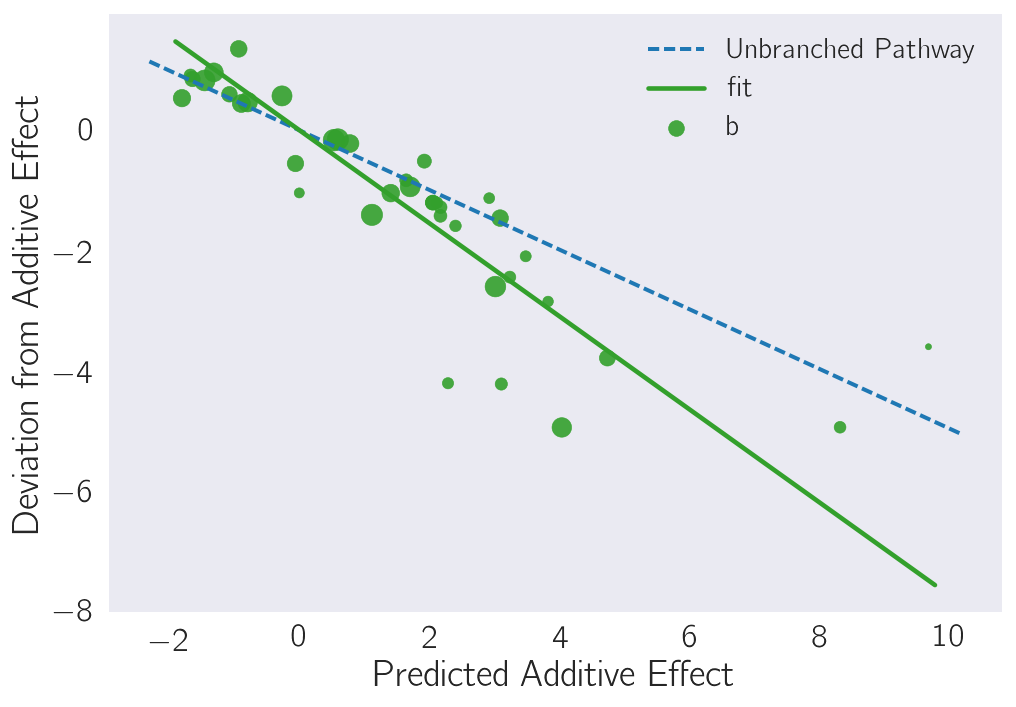

In [190]:
letter1 = 'b'
letter2 = 'c'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2], double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [191]:
s = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=5000)

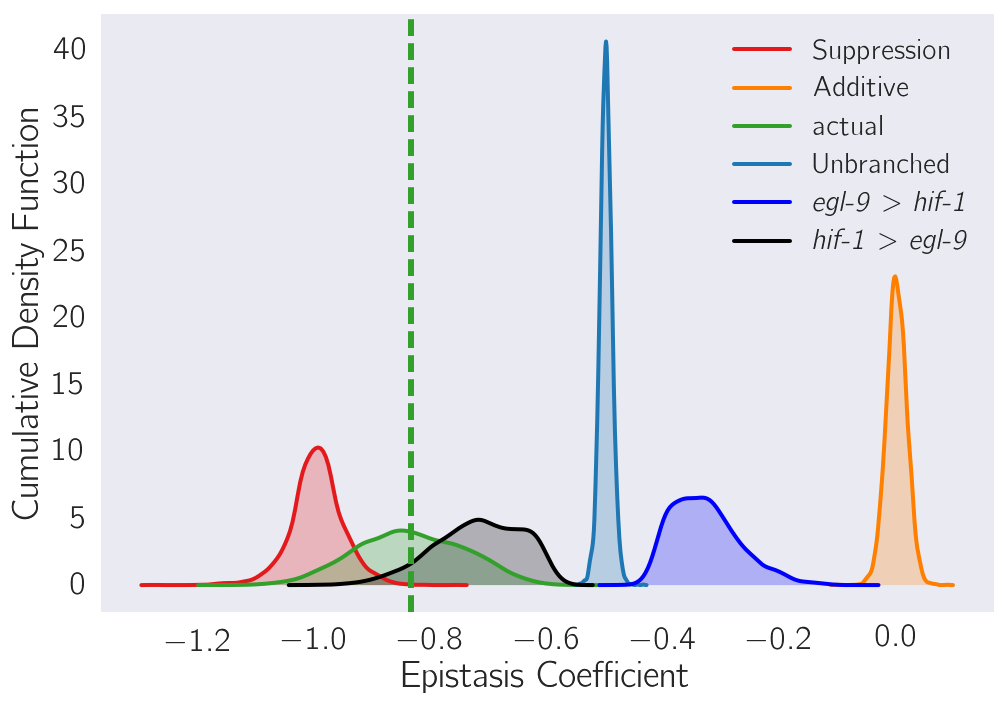

In [192]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=False, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [193]:
alpha_eglhif = {'xy=x': s['xy=x'].mean(), 
                'xy=y': s['xy=y'].mean()
                }

actual = epi.ODR([x,y], xy, epistasis='actual')
X = x.b.values + y.b.values
Y = xy.b.values - X
wdev = np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2)
model_selection(X, Y, wdev, alpha=alpha_eglhif, guess=actual.beta[0])

xy=x Odds Ratio: 1.90789e+162
xy=y Odds Ratio: 47.0109
xy=x=y Odds Ratio: 1.0016e+64
xy=x+y Odds Ratio: inf
suppress Odds Ratio: 8.4815e+25
the value used for the observed fit was -0.8 +/- 0.0171064


# Transitivity holds in transcriptomes

## Predicting the epistasis between *egl-9* and *vhl-1* using the *rhy-1* transcriptome

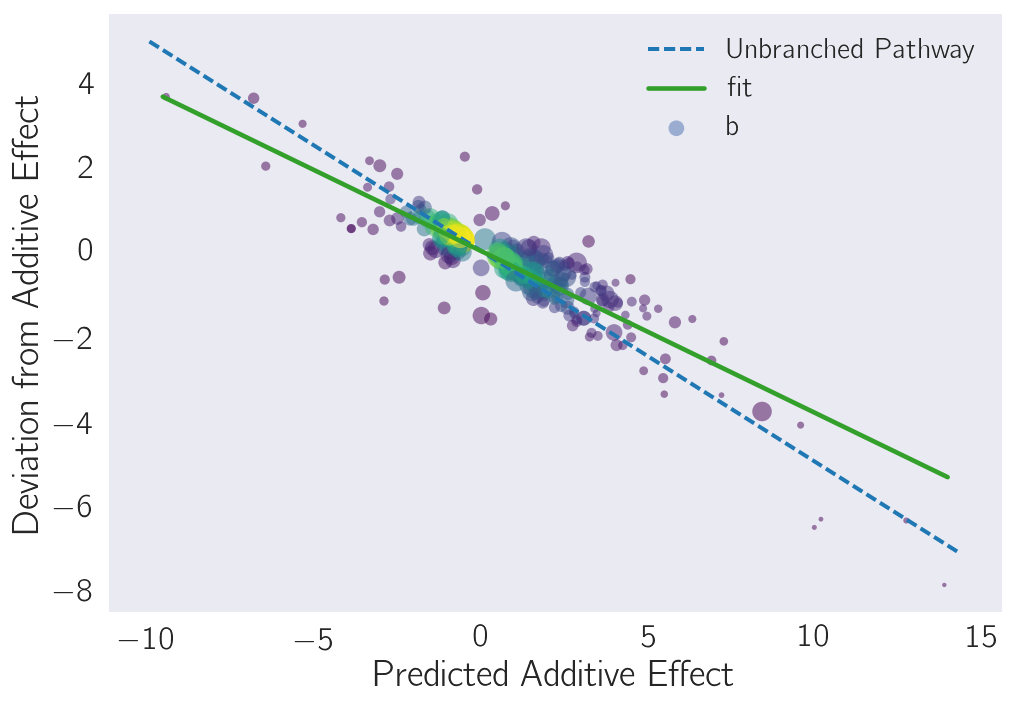

In [194]:
letter1 = 'e'
letter2 = 'd'
double = genvar.double_mapping['b' + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2], double, tidy_data)

In [195]:
s = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=5000)

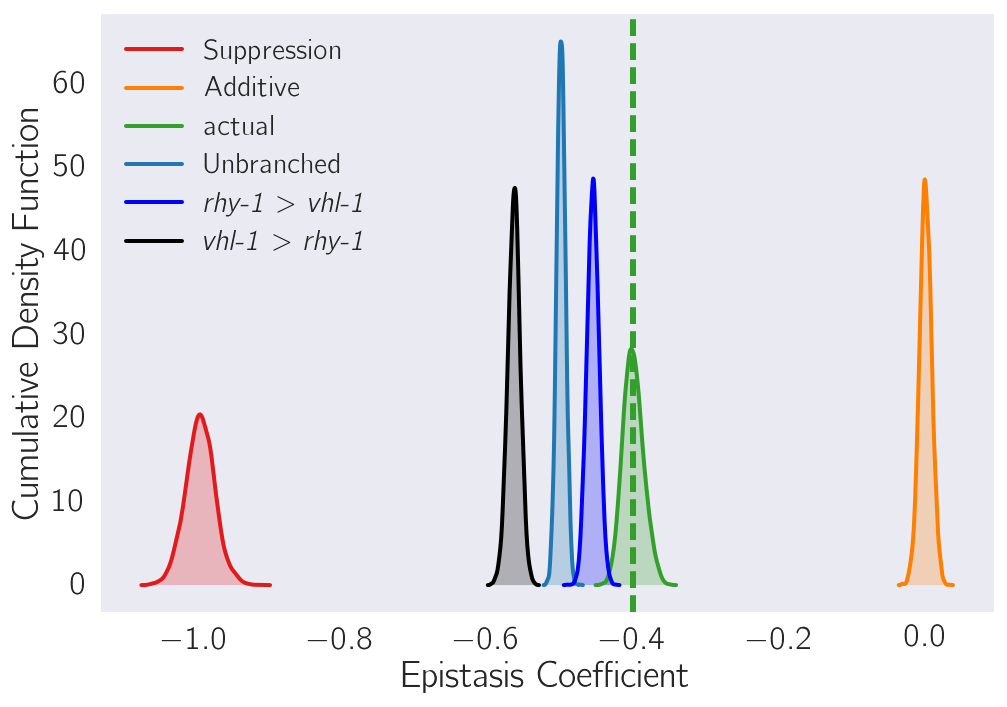

In [196]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=False, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [197]:
alpha = {'xy=x': s['xy=x'].mean(), 
         'xy=y': s['xy=y'].mean()
        }

actual = epi.ODR([x,y], xy, epistasis='actual')
X = x.b.values + y.b.values
Y = xy.b.values - X
wdev = np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2)
model_selection(X, Y, wdev, alpha=alpha, guess=actual.beta[0])

xy=x Odds Ratio: 5.22727e+25
xy=y Odds Ratio: 1.49357e+140
xy=x=y Odds Ratio: 7.25046e+62
xy=x+y Odds Ratio: inf
suppress Odds Ratio: inf
the value used for the observed fit was -0.37 +/- 0.00764108


## Predicting the epistasis between *egl-9* and *hif-1* using the *rhy-1* transcriptome

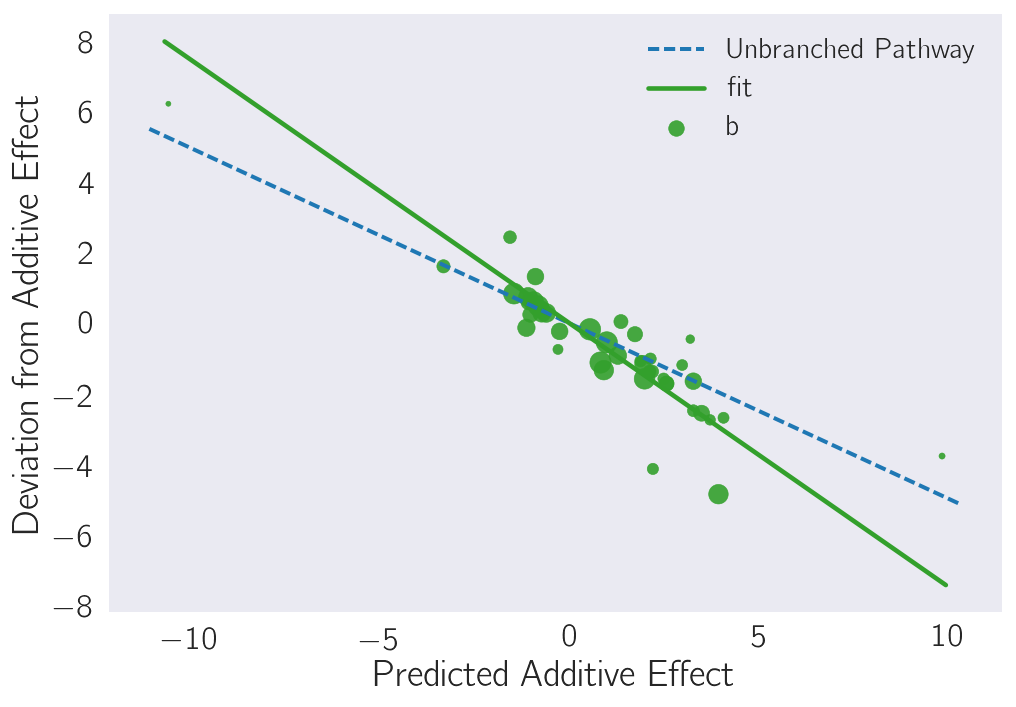

In [198]:
letter1 = 'e'
letter2 = 'c'
double = genvar.double_mapping['b' + letter2]
x, y, xy, ax = epi.epistasis_plot([letter1, letter2], double, tidy_data)

In [199]:
s = epi.calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=5000)

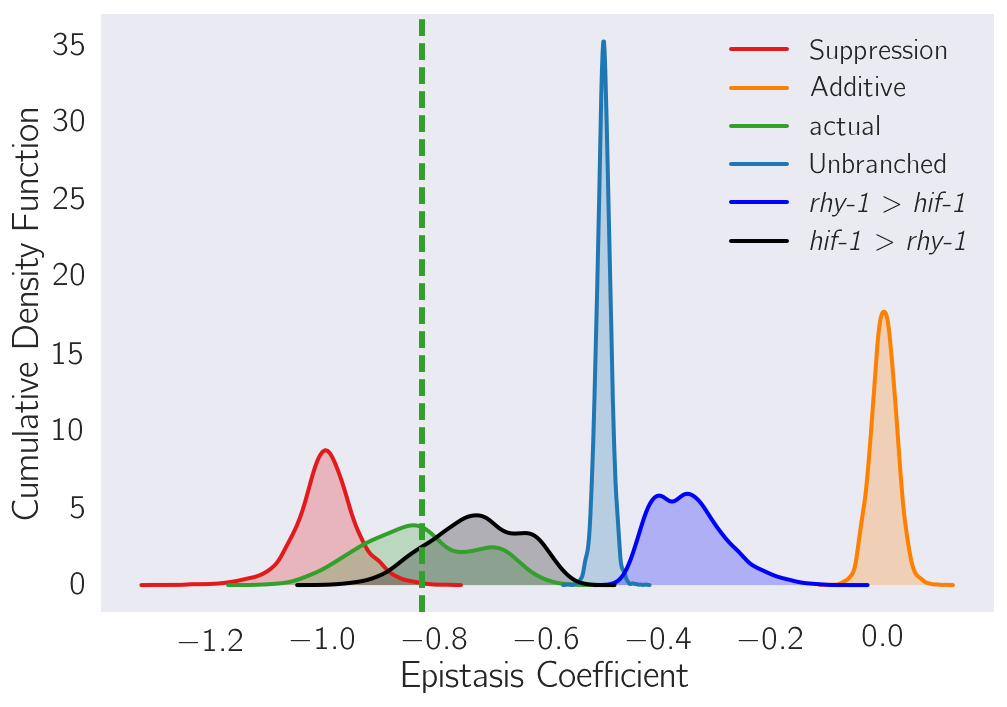

In [200]:
ax = epi.plot_bootstraps(letter1, letter2, s, cumulative=False, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [211]:
alpha = {'xy=x': s['xy=x'].mean(), 
         'xy=y': s['xy=y'].mean()
        }

actual = epi.ODR([x,y], xy, epistasis='actual')
X = x.b.values + y.b.values
Y = xy.b.values - X
wdev = np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2)
model_selection(X, Y, wdev, alpha=alpha, guess=actual.beta[0])

xy=x Odds Ratio: 4.8435e+107
xy=y Odds Ratio: 0.0464819
xy=x=y Odds Ratio: 5.44752e+43
xy=x+y Odds Ratio: inf
suppress Odds Ratio: 7.72757e+23
the value used for the observed fit was -0.784 +/- 0.0193
